In [47]:
from pydataxm import *                           #Se realiza la importación de las librerias necesarias para ejecutar                        
from pydataxm.pydataxm import ReadDB as apiXM 
import datetime as dt                            
import pandas as pd
from pathlib import Path
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler

In [2]:
s_path=Path.cwd()
#s_prt_path=s_path.parent

sRutaPrint=s_path.joinpath('Print')
sRutaPrint

df_data=pd.read_excel(str(sRutaPrint) + '\GenRealDia.xlsx', sheet_name='GendiaMenor')
df_dataAp=pd.read_excel(str(sRutaPrint) + '\AportesDia.xlsx', sheet_name='AportesDia')

In [3]:
# Función para asignar los días de la semana a cada fecha, si es festivo se trata como un domingo
import holidays
co_holidays = holidays.Colombia()

def typedays(row,tipo):

     if tipo=='Weekday':
          return row['Date'].weekday()
     elif tipo=='TypeDay':
          if row['Date'] in co_holidays:
               return 3
          elif row['Date'].weekday()==5:
               return 2
          elif row['Date'].weekday()==6:
               return 3
          else:
               return 1
     elif tipo=='Month':
          return row['Date'].month
     elif tipo=='Year':
          return row['Date'].year

In [4]:
def train_test_split(dataframe, porcentaje):
  ntrain = int(len(dataframe)*porcentaje)
  ntest = len(dataframe) - ntrain

  if ntest==0:
    datos_train = dataframe[:]
    datos_test  = []  
  else:
    datos_train = dataframe[:-ntest]
    datos_test  = dataframe[-ntest:]

  return ntrain, datos_train, ntest, datos_test

In [48]:
def Prediction_graphs(dfModel,pred_test):
  fig, ax = plt.subplots(figsize=(20, 5))
  fig.suptitle('Resultado de la predicción de Genración')
  plt.plot(dfModel['Date'], dfModel['Gendia'],label='Original')
  plt.plot(pred_test['Date'], pred_test['pred'],label='Test')
  ax.set_ylabel('Generación MWh/día')
  ax.set_facecolor('white')
  ax.legend()

  ntest=pred_test.shape[0]

  fig, ax = plt.subplots(figsize=(20, 5))
  plt.plot(dfModel['Date'][-ntest:], dfModel['Gendia'][-ntest:],label='Original')
  plt.plot(pred_test['Date'], pred_test['pred'],label='Test')
  ax.set_ylabel('Gen [MWh/dia]')
  ax.legend()


  fig, ax = plt.subplots(figsize=(20, 5))
  plt.plot(dfModel['Date'][-90:], dfModel['Gendia'][-90:],label='Original')
  plt.plot(pred_test['Date'][-90:], pred_test['pred'][-90:],label='Test')
  ax.set_ylabel('Gen [MWh/dia]')
  ax.legend()

In [37]:
df_GenHid=df_data.copy()
# df_GenHid=df_GenHid[df_GenHid.Values_Type=='HIDRAULICA'][['Date','Gendia','Aportes']]

df_GenHid=df_GenHid[df_GenHid.Values_Type=='HIDRAULICA'][['Date','Gendia']]

# Agregar tipo de día
df_GenHid['TypeDay']=df_GenHid.apply(lambda row: typedays(row,tipo='TypeDay'),axis=1)
# Definir día de la semana
df_GenHid['Weekday']=df_GenHid.apply(lambda row: typedays(row,tipo='Weekday'),axis=1)
# Definir mes
df_GenHid['Month']=df_GenHid.apply(lambda row: typedays(row,tipo='Month'),axis=1)
# Definir año
df_GenHid['Year']=df_GenHid.apply(lambda row: typedays(row,tipo='Year'),axis=1)

df_GenHid['d_1'] = df_GenHid['Gendia'].shift(1)  # 1-day lag
df_GenHid['d_2'] = df_GenHid['Gendia'].shift(2)  # 2-day lag
df_GenHid['d_7'] = df_GenHid['Gendia'].shift(7)  # 7-day lag
df_GenHid = df_GenHid.dropna()

dfModel=df_GenHid.copy()

# Remover la fecha al dataset
col=dfModel.columns[1:]
Fecha=dfModel[['Date']]
dfModel=dfModel[col]

In [38]:
dfModel

,Gendia,TypeDay,Weekday,Month,Year,d_1,d_2,d_7
21,4246.61898,1,1,1,2013,4213.16135,4363.09553,4925.62655
24,4133.33919,1,2,1,2013,4246.61898,4213.16135,4799.93577
27,4128.58333,1,3,1,2013,4133.33919,4246.61898,4731.06990
30,3942.48944,1,4,1,2013,4128.58333,4133.33919,4684.38623
33,3969.76991,2,5,1,2013,3942.48944,4128.58333,4620.25446
...,...,...,...,...,...,...,...,...
16016,10796.15248,1,2,8,2024,12089.23841,10471.24441,11428.73015
16021,10002.72219,1,3,8,2024,10796.15248,12089.23841,9924.44995
16026,10679.94901,1,4,8,2024,10002.72219,10796.15248,10671.31285
16031,10834.81113,2,5,8,2024,10679.94901,10002.72219,10648.33126


In [40]:
# Creating a random seed for reproducibility
np.random.seed(42)

scaler = MinMaxScaler(feature_range=(0, 1))
series = scaler.fit_transform(dfModel)


X = series[:,1:]
y = series[:,0]


ntrain, X_train, ntest, X_test = train_test_split(X, 0.8)
ntrain, y_train, ntest, y_test = train_test_split(y, 0.8)
ntrain, f_train, ntest, f_test = train_test_split(Fecha, 0.8)



In [41]:
# Initialize the XGBoost Regressor
model = XGBRegressor(
    n_estimators=100,      # Number of trees
    max_depth=3,           # Maximum depth of a tree
    learning_rate=0.1,     # Step size shrinkage
    objective='reg:squarederror',  # Loss function
    random_state=42
)

# Fit the model on the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [44]:
f_test

,Date
11873,2022-04-23
11877,2022-04-24
11881,2022-04-25
11885,2022-04-26
11889,2022-04-27
...,...
16016,2024-08-14
16021,2024-08-15
16026,2024-08-16
16031,2024-08-17


In [45]:
# Make predictions on the test set
y_pred = model.predict(X_test)
pred_test= scaler.inverse_transform(np.hstack((y_pred.reshape(X_test.shape[0],1), X_test)))
pred_test = pd.DataFrame({'Date':f_test['Date'],'pred':pred_test[:, 0]})

In [7]:
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 349508.1562755749


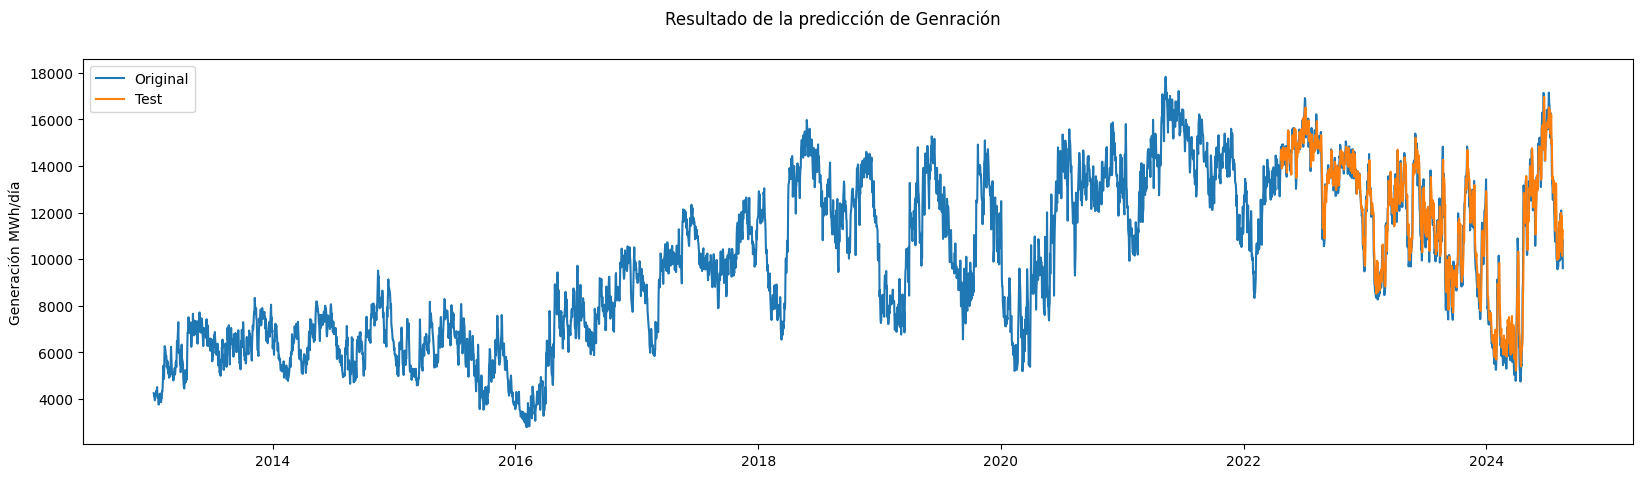

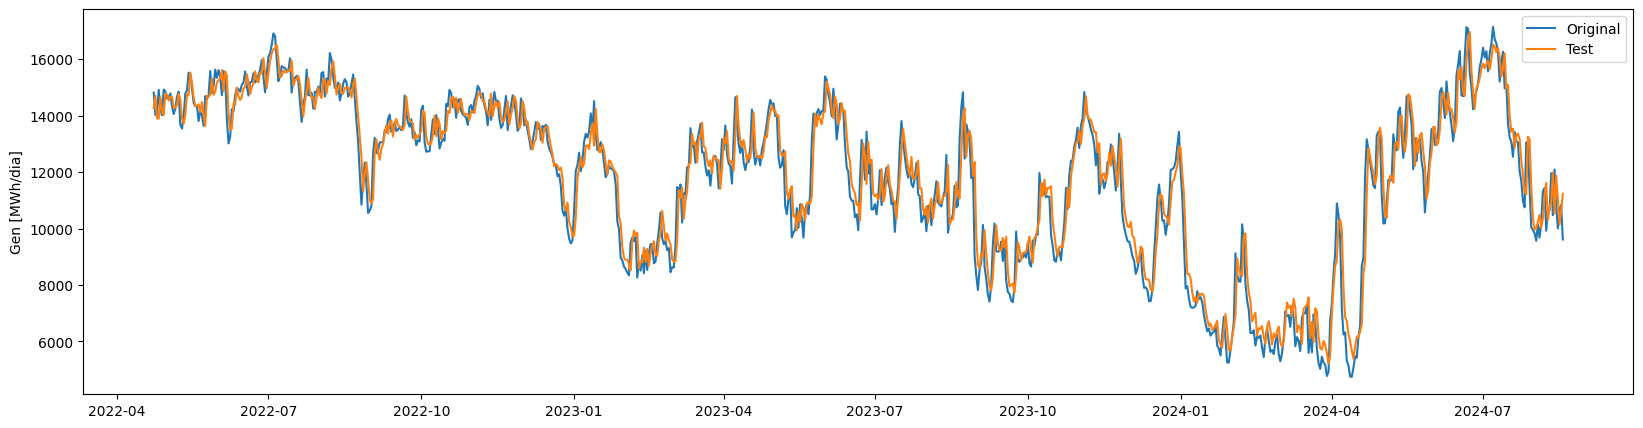

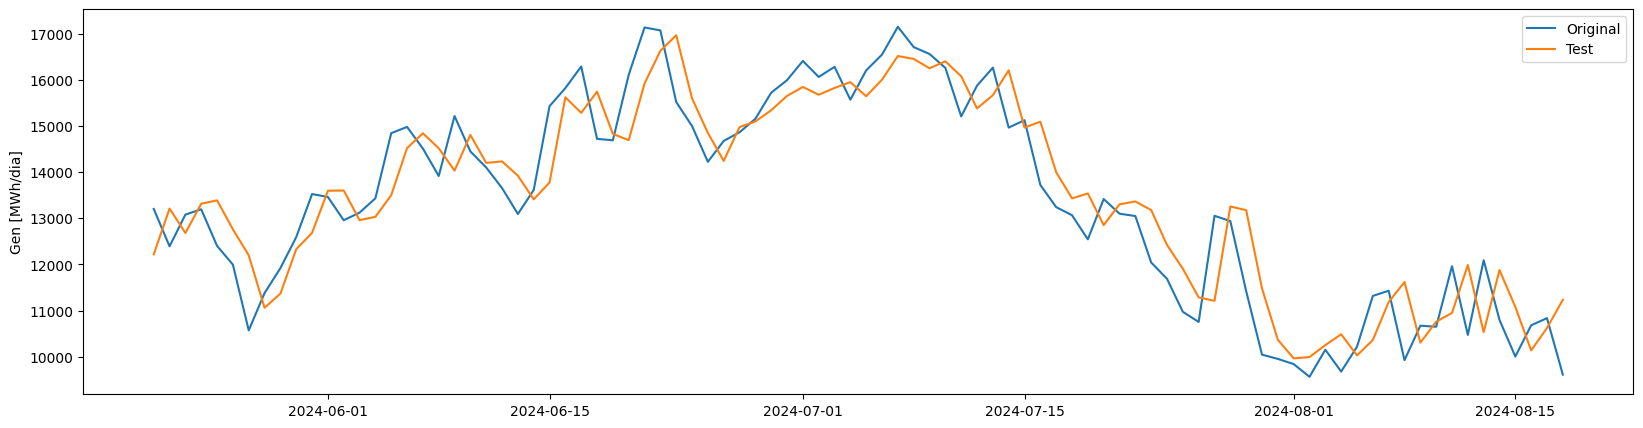

In [49]:
Prediction_graphs(df_GenHid,pred_test)
